In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('purchase_data.csv')

In [3]:
data.shape

(541909, 8)

Get familiar with the data

In [5]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01/12/2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01/12/2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01/12/2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01/12/2010 08:26,3.39,17850.0,United Kingdom


examining the initial entries, we notice that a customer with ID 17850, based in the United Kingdom, placed an order under InvoiceNo 536365. This order includes multiple products, each identified by a unique stock code, description, unit price, and quantity. Additionally, all these products share the same InvoiceDate, indicating they were part of the same purchase.

Get an initial feeling for the data by exploration

In [8]:
missing_value = data.isnull().sum() 
missing_presentage = missing_value / data.shape[0] * 100

print(f"Missing Presentage:")
print(missing_presentage)

Missing Presentage:
InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64


In [10]:
#Missing descriptions

data[data.Description.isnull()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01/12/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,01/12/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,01/12/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,01/12/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,01/12/2010 14:34,0.0,NaN,United Kingdom


In [11]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()

CustomerID
True    1454
Name: count, dtype: int64

In [13]:
#Missing Customer IDs
data[data.CustomerID.isnull()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,01/12/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,01/12/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,01/12/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,01/12/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,01/12/2010 14:32,1.66,NaN,United Kingdom


In [14]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


The price and the quantities of entries without a customer ID can show extreme outliers. As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive. 

Hidden missing descriptions. Try find a nun-string create a new feature that hold descriptions in lowercase.

In [17]:
import numpy as np


data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

lowercase_descriptions
False    539724
True        731
Name: count, dtype: int64

In [18]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

lowercase_descriptions
False    540455
Name: count, dtype: int64

found additional, hidden nan-values that show a string "nan" instead of a nan-value. Then transform them to NaN

In [20]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [21]:
data.isnull().sum().sum()

0

The Time period in the Days

In [23]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, dayfirst=True, cache=True)

date_range = data.InvoiceDate.max() - data.InvoiceDate.min()
print(date_range)



373 days 04:24:00


In [24]:
print("Start timepoint {}".format(data.InvoiceDate.min()))
print("Ends timepoint {}".format(data.InvoiceDate.max()))

Start timepoint 2010-12-01 08:26:00
Ends timepoint 2011-12-09 12:50:00


The invoice number

In [26]:
#Unic Invoce numbers

data.InvoiceNo.nunique()

22190

In the data description we can find that a cancelled transactions starts with a "C" in front of it. Let's create a feature to easily filter out these cases

In [28]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)

data.IsCancelled.value_counts() / data.shape[0] * 100

IsCancelled
False    97.81112
True      2.18888
Name: count, dtype: float64

2.18 % of all entries are cancellations.

In [30]:
data.loc[data.IsCancelled==True].describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,8905.000000,8905,8905.000000,8905.000000
mean,-30.859966,2011-06-27 06:17:46.598540032,18.845519,14991.667266
min,-80995.000000,2010-12-01 09:41:00,0.010000,12346.000000
25%,-6.000000,2011-03-22 16:07:00,1.450000,13510.000000
50%,-2.000000,2011-07-11 13:51:00,2.950000,14895.000000
75%,-1.000000,2011-10-06 20:36:00,4.950000,16393.000000
max,-1.000000,2011-12-09 11:58:00,38970.000000,18282.000000
std,1170.154939,NaN,444.366043,1706.772357


All cancellations have negative quantites but positive, non-zero unit prices.

Looking at the data, it’s hard to understand why a customer made a return. Predicting such cases is also challenging since there could be many hidden reasons for cancellations. so i have remove these cases.

In [33]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

In [34]:
#unique stockcodes

data.StockCode.nunique()

3665

Most Common Codes identify

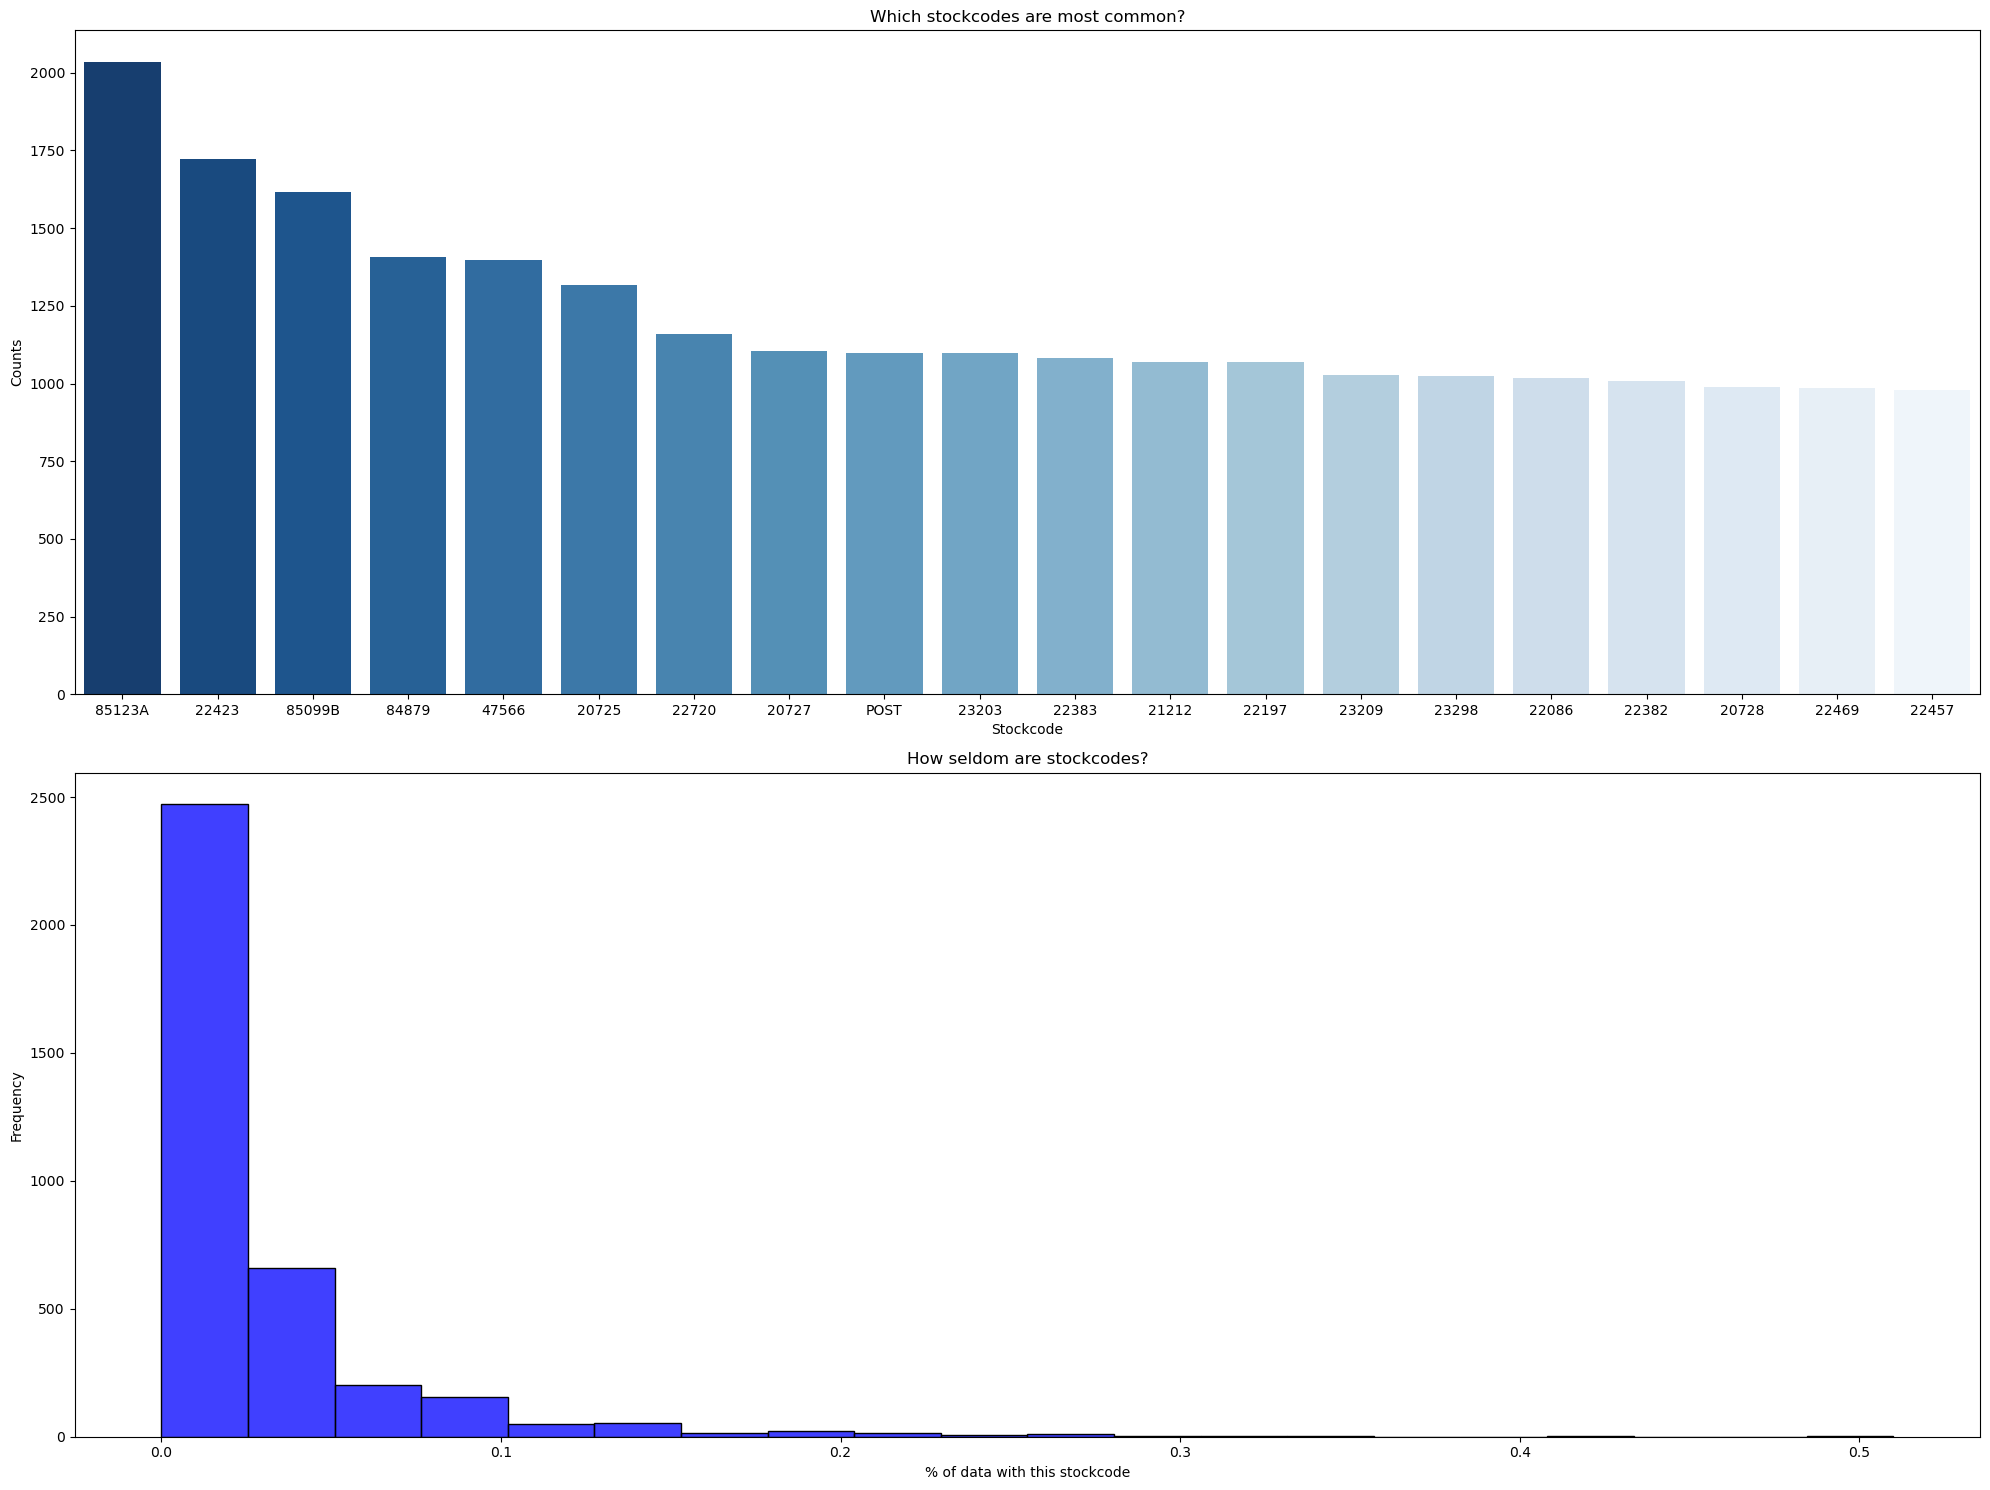

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)

# Create the plots
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# Barplot for most common stockcodes
sns.barplot(
    x=stockcode_counts.iloc[0:20].index,
    y=stockcode_counts.iloc[0:20].values,
    ax=ax[0],
    palette=sns.color_palette("Blues_r", n_colors=20),
    hue  = stockcode_counts.iloc[0:20].index
)
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?")

# Distribution plot for stockcode frequency
sns.histplot(
    np.round(stockcode_counts / data.shape[0] * 100, 2),
    bins=20,
    ax=ax[1],
    color="blue"
)
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()




count the number of numeric chars in and the length of the stockcode

In [39]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

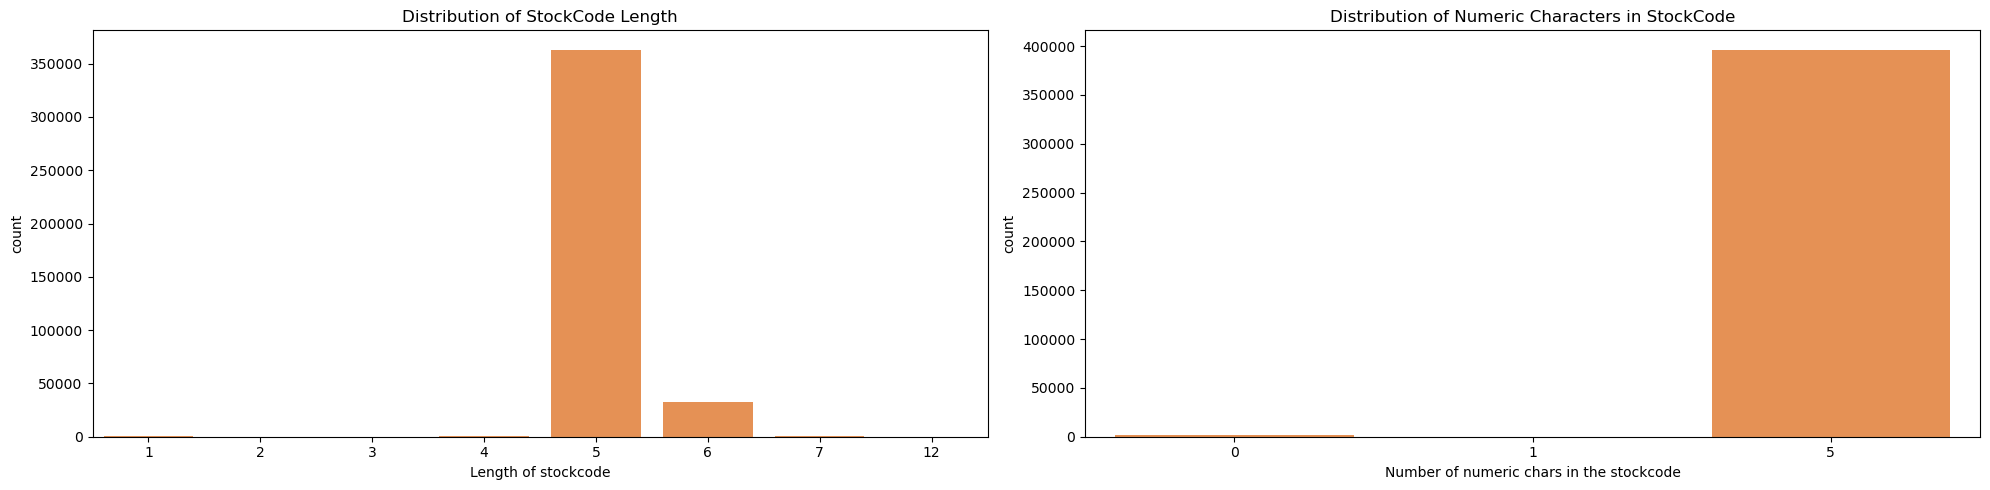

In [40]:
# Create dummy hue for compatibility
data["DummyHue"] = "All"

fig, ax = plt.subplots(1, 2, figsize=(20, 5))

sns.countplot(x=data["StockCodeLength"], hue=data["DummyHue"], palette="Oranges_r", ax=ax[0], dodge=False)
ax[0].legend_.remove()  # Remove the legend
ax[0].set_xlabel("Length of stockcode")
ax[0].set_title("Distribution of StockCode Length")

sns.countplot(x=data["nNumericStockCode"], hue=data["DummyHue"], palette="Oranges_r", ax=ax[1], dodge=False)
ax[1].legend_.remove()  # Remove the legend
ax[1].set_xlabel("Number of numeric chars in the stockcode")
ax[1].set_title("Distribution of Numeric Characters in StockCode")

plt.tight_layout()
plt.show()


In [41]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

lowercase_descriptions
postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: count, dtype: int64

gain something that we don't want to predict. Again this indicates that the retailer does not speparate well between special kind of transactions and valid customer-retailer transactions. Let's drop all of these occurences:

In [43]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()


2785

In [44]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

Descriptions

In [46]:
data.Description.nunique()

2985

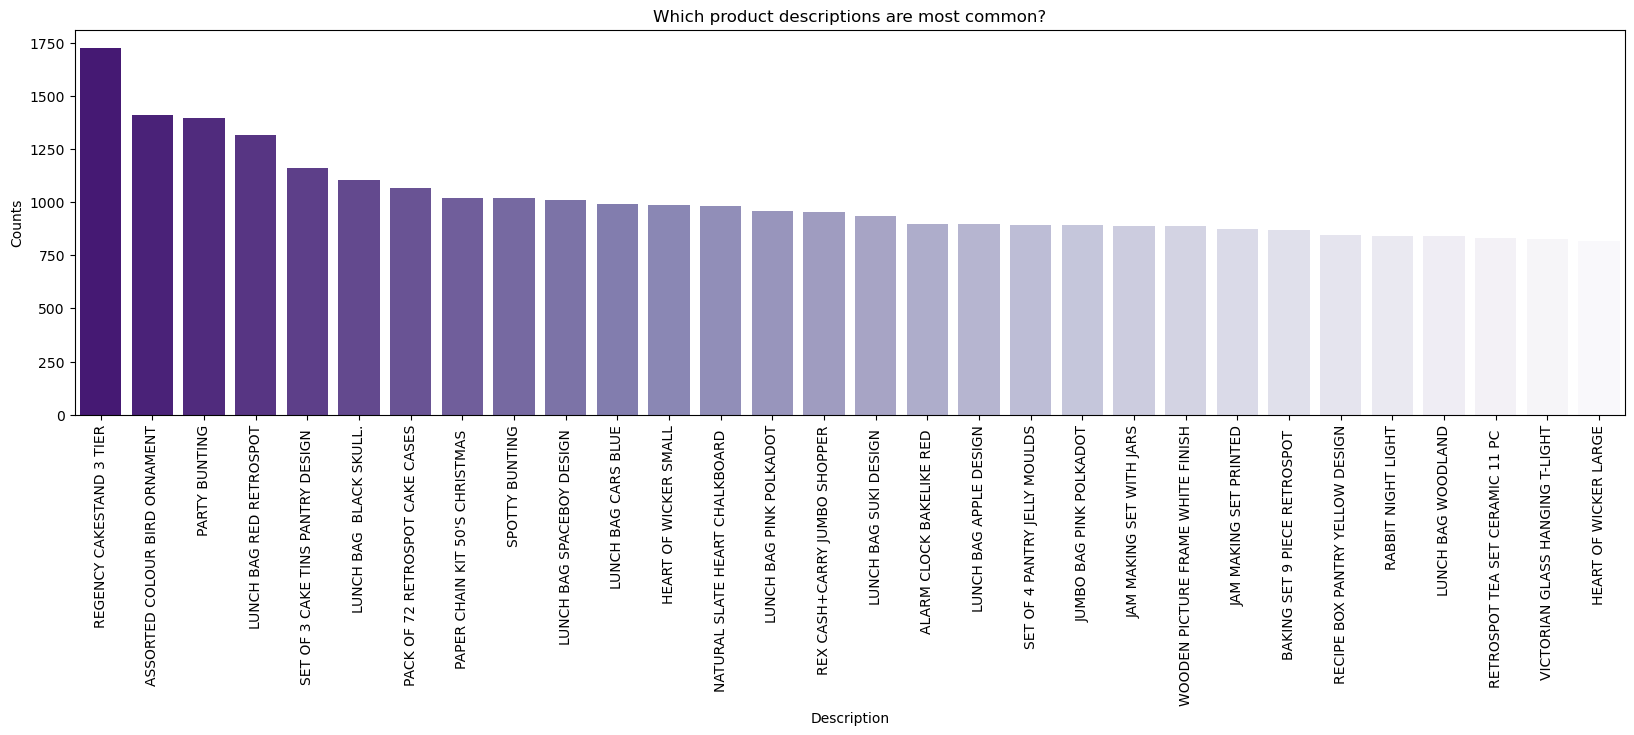

In [47]:
# Compute the counts for the top 30 product descriptions
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]

# Create the bar plot
plt.figure(figsize=(20, 5))
sns.barplot(
    x=description_counts.index, 
    y=description_counts.values, 
    palette="Purples_r",
    hue = description_counts.index
)
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?")
plt.xticks(rotation=90)
plt.show()


Some product descriptions seem to refer to similar items, like "lunch bags," which show up multiple times with slight differences. Often, the descriptions also include color details. The most common descriptions show that the retailer sells a variety of products.

All descriptions are written in uppercase letters, so there don’t seem to be any lowercase characters.

Then I analyze the descriptions by looking at their length and checking if there are any lowercase characters.

In [49]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [50]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

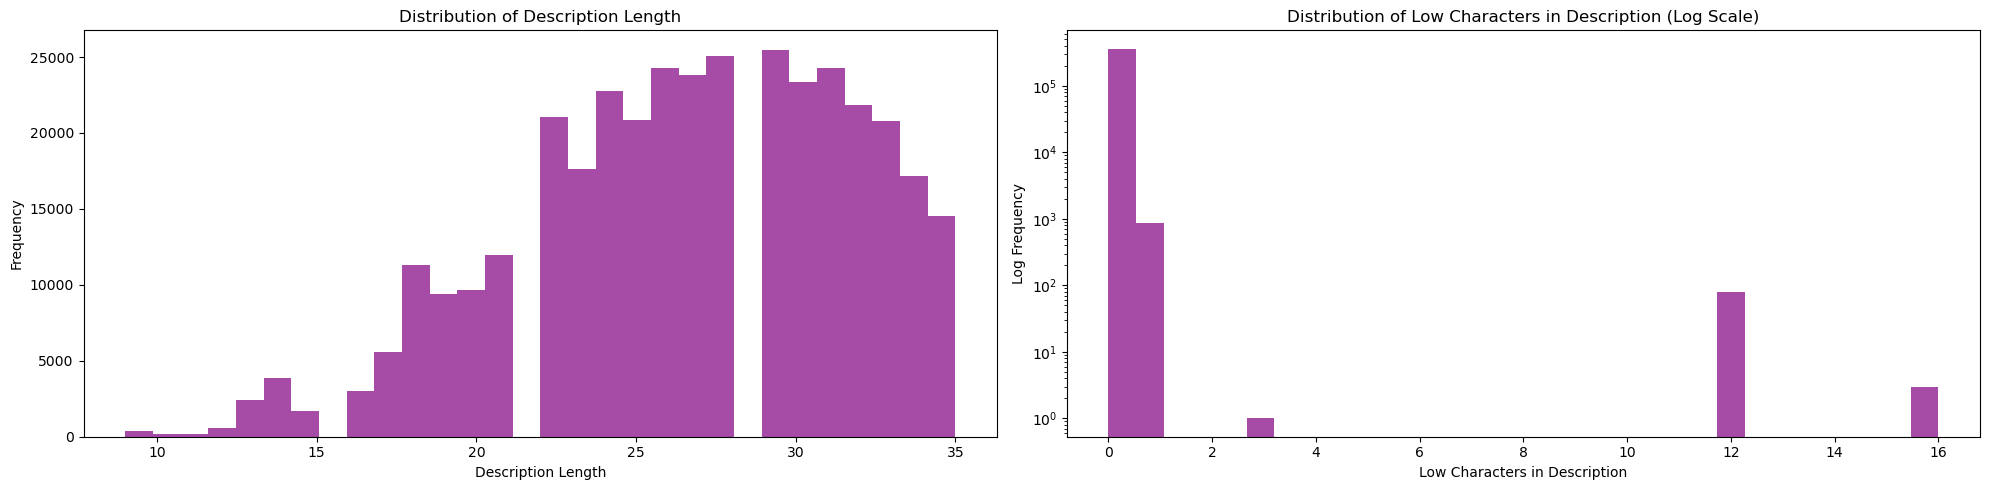

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot histogram for DescriptionLength
ax[0].hist(data['DescriptionLength'], bins=30, color="Purple", alpha=0.7)
ax[0].set_title("Distribution of Description Length")
ax[0].set_xlabel("Description Length")
ax[0].set_ylabel("Frequency")

# Plot histogram for LowCharsInDescription
ax[1].hist(data['LowCharsInDescription'], bins=30, color="Purple", alpha=0.7)
ax[1].set_yscale("log")
ax[1].set_title("Distribution of Low Characters in Description (Log Scale)")
ax[1].set_xlabel("Low Characters in Description")
ax[1].set_ylabel("Log Frequency")

plt.tight_layout()
plt.show()


C:\Users\User\AppData\Local\Temp\ipykernel_9556\2655239368.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


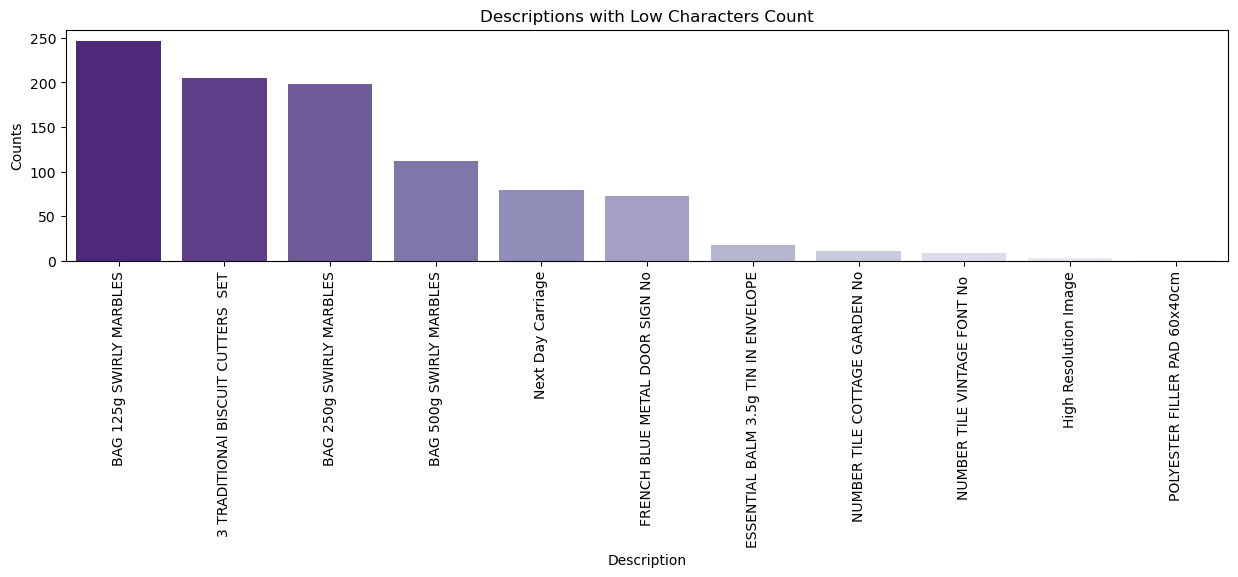

In [52]:
# Filter and count descriptions with low characters
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

# Create the bar plot
plt.figure(figsize=(15, 3))
sns.barplot(
    x=lowchar_counts.index, 
    y=lowchar_counts.values, 
    palette="Purples_r",
    hue =lowchar_counts.index
)
plt.xticks(rotation=90)
plt.title("Descriptions with Low Characters Count")
plt.xlabel("Description")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


In [53]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [54]:
data.UpCharsInDescription.describe()

count    363119.000000
mean         22.574429
std           4.351604
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64

In [55]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

Description
Next Day Carriage        79
High Resolution Image     3
Name: count, dtype: int64

In [56]:
data = data.loc[data.UpCharsInDescription > 5].copy()

And what about the descriptions with a length below 14

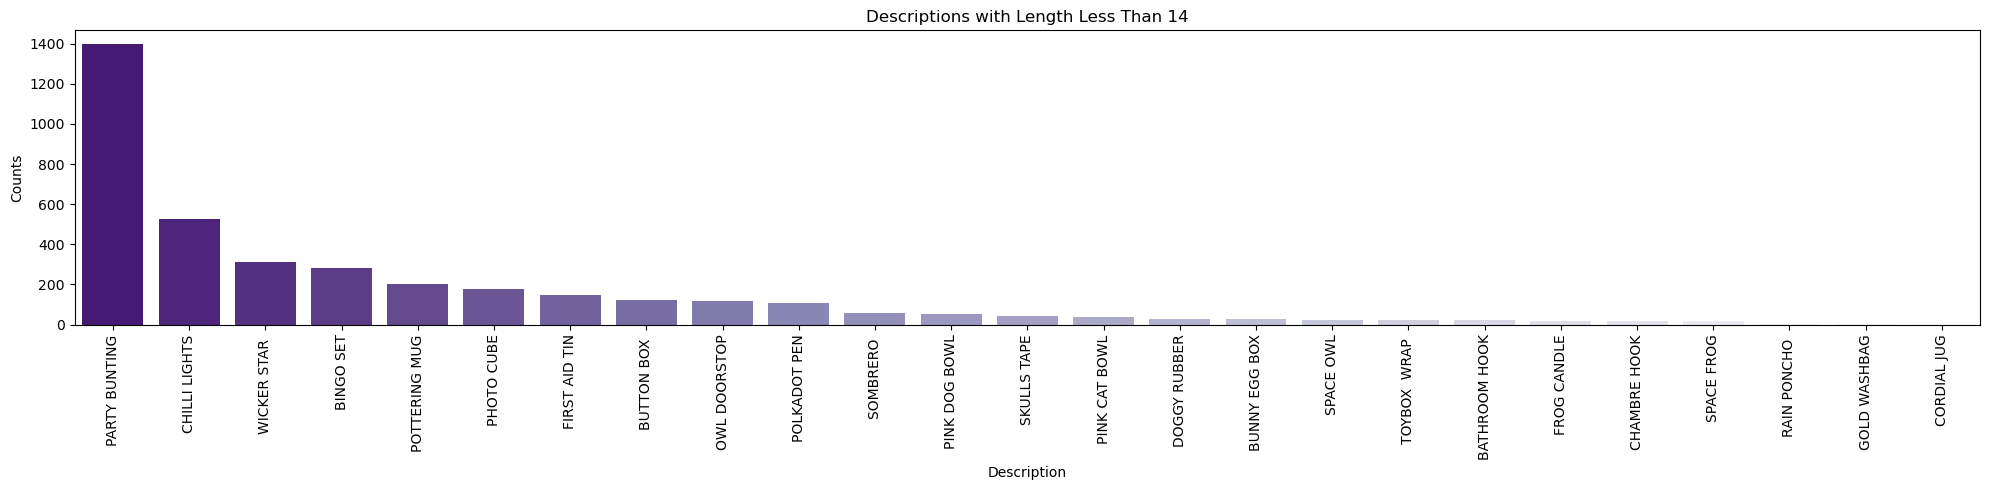

In [58]:
# Filter and count descriptions with length less than 14
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

# Create the bar plot
plt.figure(figsize=(20, 5))
sns.barplot(
    x=dlength_counts.index, 
    y=dlength_counts.values, 
    palette="Purples_r",
    hue = dlength_counts.index
)
plt.xticks(rotation=90)
plt.title("Descriptions with Length Less Than 14")
plt.xlabel("Description")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


In [59]:
data.StockCode.nunique()

2783

In [60]:
data.Description.nunique()

2983

Still have more descriptions than stockcodes and we should continue to find out why they differ.

In [62]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23236    4
23196    4
23126    3
23396    3
23240    3
23231    3
23370    3
23535    3
23203    3
23244    3
Name: Description, dtype: int64

In [63]:
data.loc[data.StockCode == "23244"].Description.value_counts()

Description
ROUND STORAGE TIN VINTAGE LEAF    96
STORAGE TIN VINTAGE LEAF           7
CANNISTER VINTAGE LEAF DESIGN      2
Name: count, dtype: int64

Customers 

In [65]:
data.CustomerID.nunique()

4315

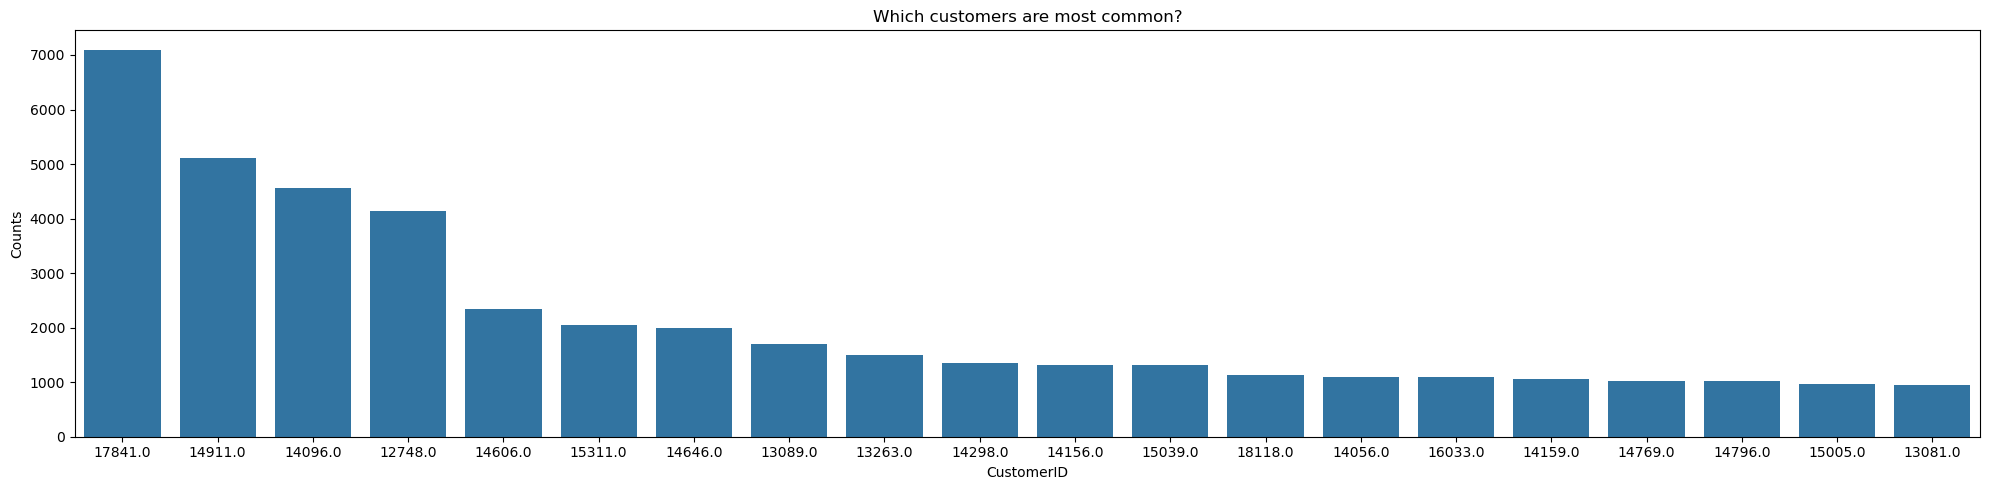

In [66]:
# Get the top 20 customers by transaction count
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20]

# Create the bar plot
plt.figure(figsize=(20, 5))
sns.barplot(
    x=customer_counts.index, 
    y=customer_counts.values, 
    order=customer_counts.index
)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?")
plt.tight_layout()
plt.show()


How many unique countries are delivered by the retailer

In [68]:
data.Country.nunique()

37

which ones are most common

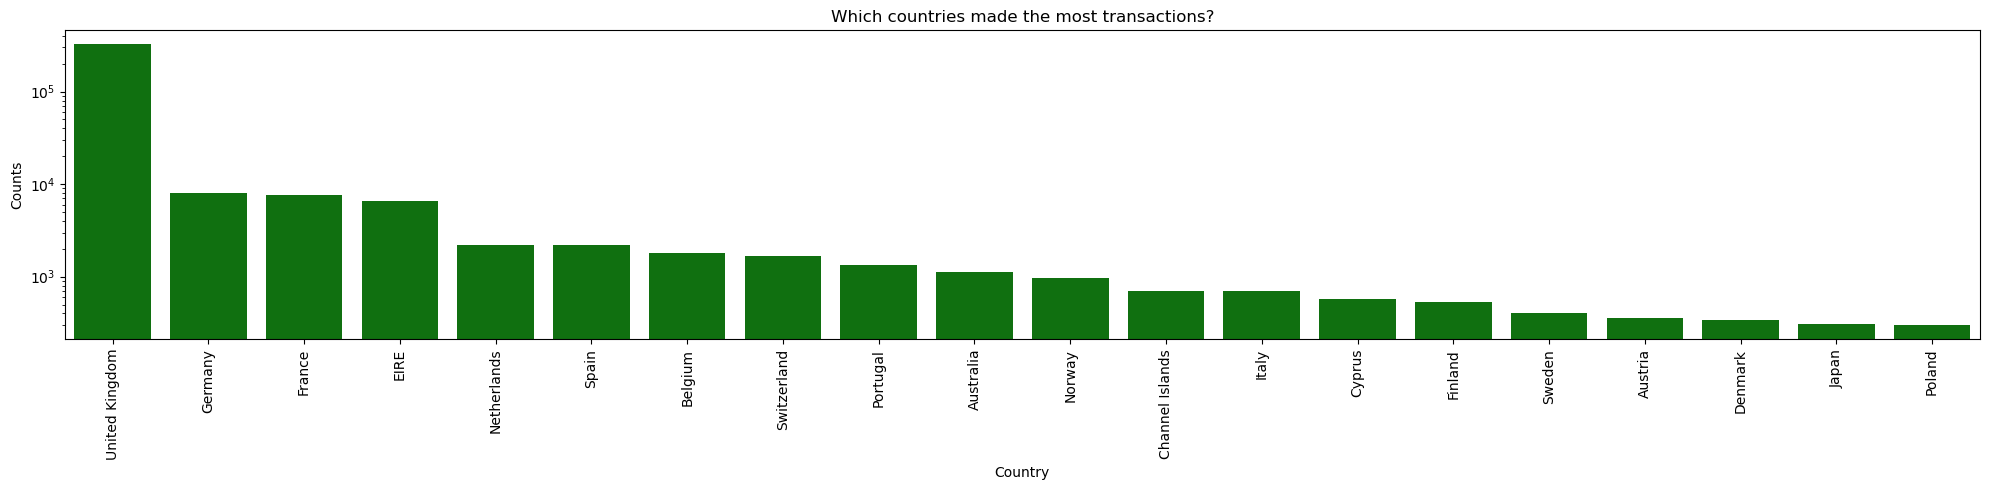

In [70]:
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]

plt.figure(figsize=(20, 5))

# Use barplot without palette or with explicit hue assignment
sns.barplot(
    x=country_counts.index, 
    y=country_counts.values, 
    color="green"  # Use a single color instead of palette
)

plt.ylabel("Counts")
plt.title("Which countries made the most transactions?")
plt.xticks(rotation=90)
plt.yscale("log")
plt.tight_layout()
plt.show()


Most of the products are sold in the UK, followed by other European countries

In [72]:
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.11047634263174

In [73]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

In [74]:
data.UnitPrice.describe()

count    363037.000000
mean          2.883374
std           4.358511
min           0.000000
25%           1.250000
50%           1.690000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

In [75]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DummyHue,DescriptionLength,LowCharsInDescription,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256.0,United Kingdom,asstd design 3d paper stickers,All,30,0,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911.0,EIRE,set of 6 nativity magnets,All,26,0,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415.0,Australia,biscuit tin vintage christmas,All,29,0,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646.0,Netherlands,set of 2 ceramic christmas reindeer,All,35,0,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646.0,Netherlands,polkadot rain hat,All,18,0,15,0


In [76]:
data = data.loc[data.UnitPrice > 0].copy()

In [77]:
np.exp(-2)

0.1353352832366127

In [78]:
np.exp(3)

20.085536923187668

In [79]:
np.quantile(data.UnitPrice, 0.95)

8.5

Transactions with prices that fall into this range as we don't want to make predictions for very seldom products with high prices. 

In [81]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

Quantities

In [83]:
data.Quantity.describe()

count    362205.000000
mean         13.020969
std         187.412814
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

Ok, most products are sold in quantities from 1 to 12. But, we have extreme, unrealistic outliers again

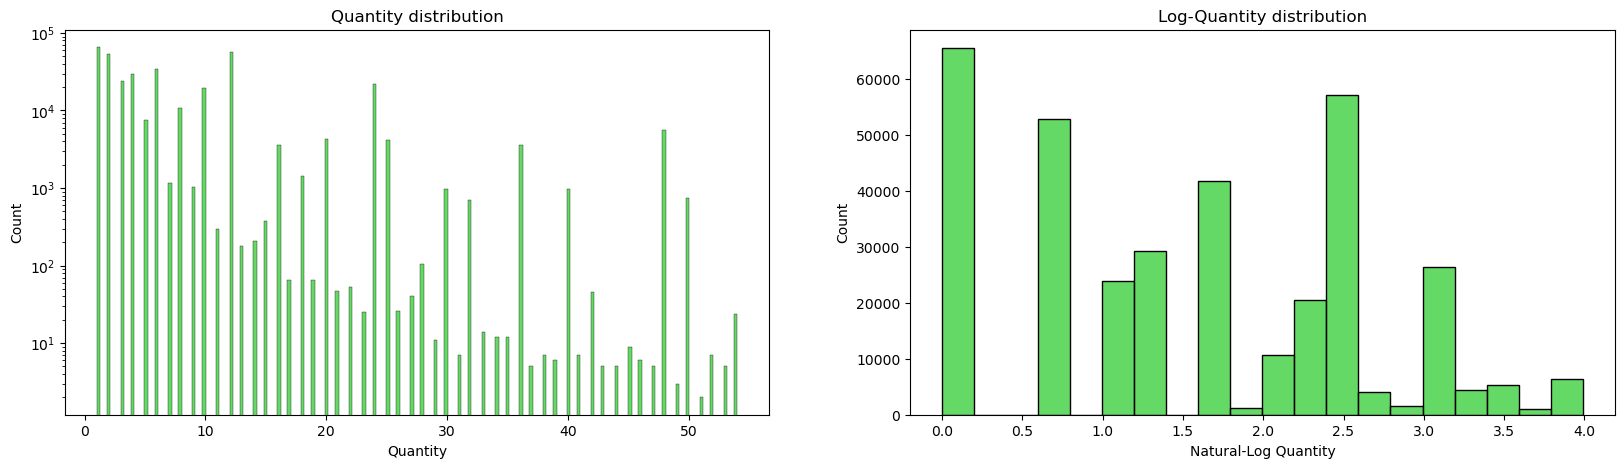

In [144]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# First plot: Quantity distribution
sns.histplot(data.Quantity, ax=ax[0], kde=False, color="limegreen")
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")

# Second plot: Log-Quantity distribution
sns.histplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity")

plt.show()

In [86]:
np.exp(4)

54.598150033144236

In [87]:
np.quantile(data.Quantity, 0.95)

36.0

In this case we would still cover more than 95 % of the data

In [89]:
data = data.loc[data.Quantity < 55].copy()

Revenues

Focus on daily product sales

To predict daily product sales, I need to group the data by each day. For this, I can extract date-related information from the InvoiceDate. I also need to calculate the revenue for each transaction by multiplying the UnitPrice with the Quantity.

In [93]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.isocalendar().week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

In [94]:
grouped_features = ["Date", "Year", "Quarter","Month","Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

Aggregate the revenue

In [96]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [97]:
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,196133.000000,196133.000000
mean,14.972865,28.190322
std,18.812748,43.924544
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.750000
max,411.000000,1266.300000


As seen from the minimum and maximum values, the target variable has extreme outliers. If I want to use it as a target, I should exclude these outliers, as they can mislead the validation process. 

In [99]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 89.0)


In [100]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


In [102]:
samples = daily_data.shape[0]

In [103]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [104]:
samples - daily_data.shape[0]

5243

remaining distributions of daily quantities

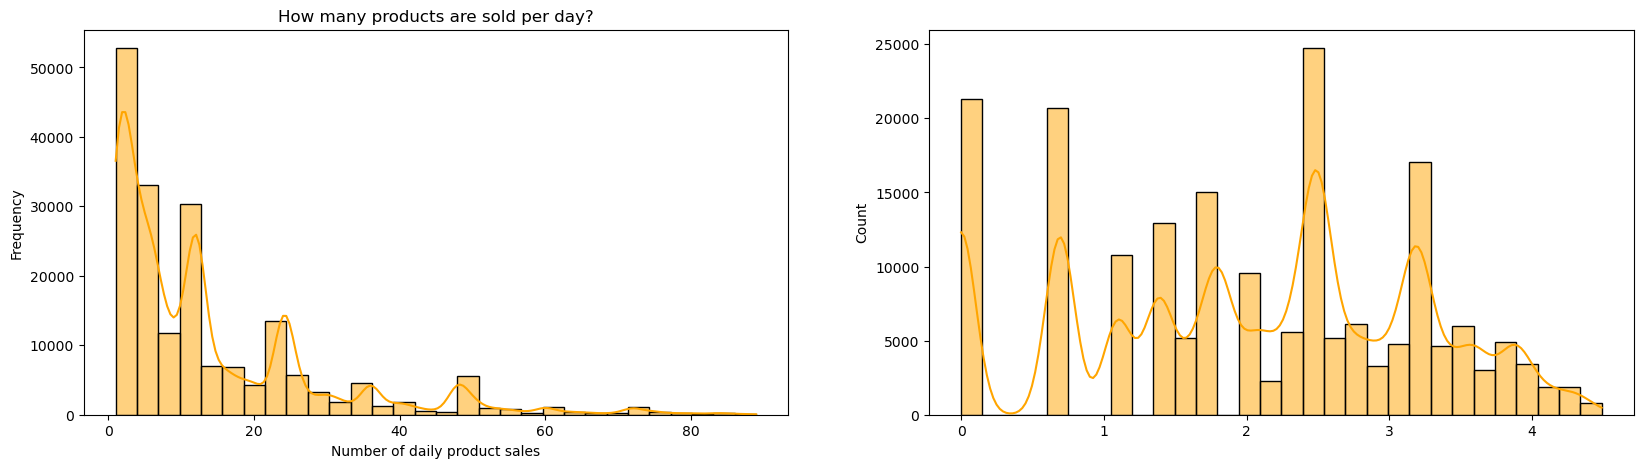

In [128]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.histplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.histplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

1. Monthly fluctuations in revenue and transactions

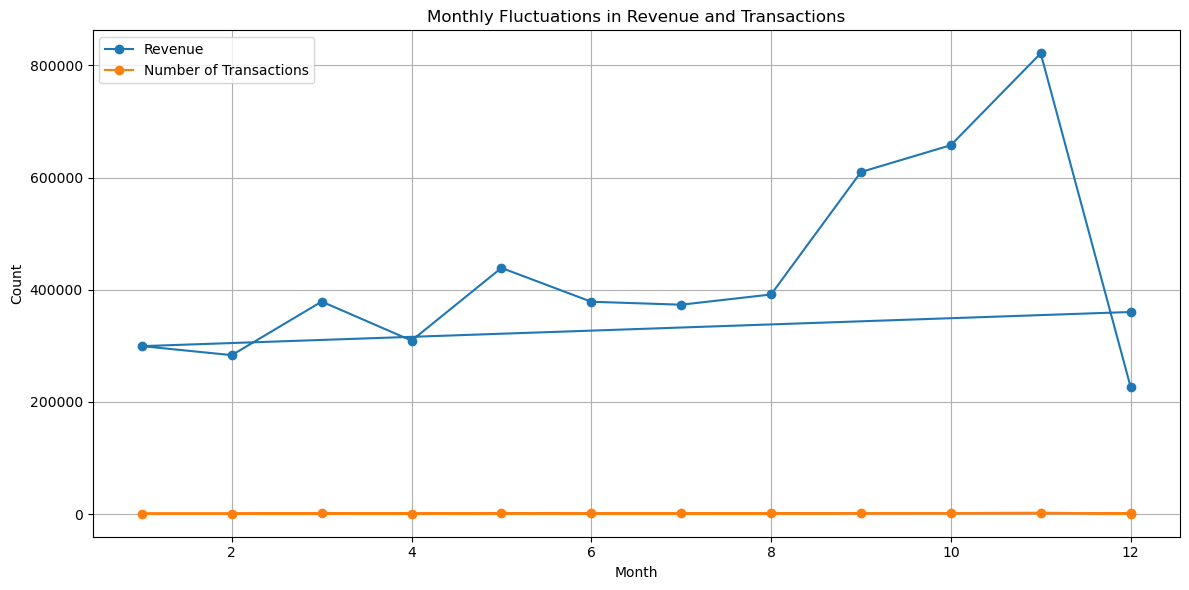

Potential anomalies identified in the months with largest revenue spikes.


In [108]:

monthly_data = data.groupby(['Year', 'Month']).agg({
    'Revenue': 'sum',
    'InvoiceNo': 'nunique'
}).reset_index()

# Plotting monthly trends
plt.figure(figsize=(12, 6))
plt.plot(monthly_data['Month'], monthly_data['Revenue'], marker='o', label='Revenue')
plt.plot(monthly_data['Month'], monthly_data['InvoiceNo'], marker='o', label='Number of Transactions')
plt.title('Monthly Fluctuations in Revenue and Transactions')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Insights
print("Potential anomalies identified in the months with largest revenue spikes.")


2. Determine which product categories have the highest total revenue and demonstrate consistent revenue growth trends. Identify any categories with sustained increases in sales.

Top 5 Categories by Revenue:
StockCode
22423    111996.55
47566     51068.83
84879     33697.22
23298     30314.15
22086     27161.93
Name: Revenue, dtype: float64


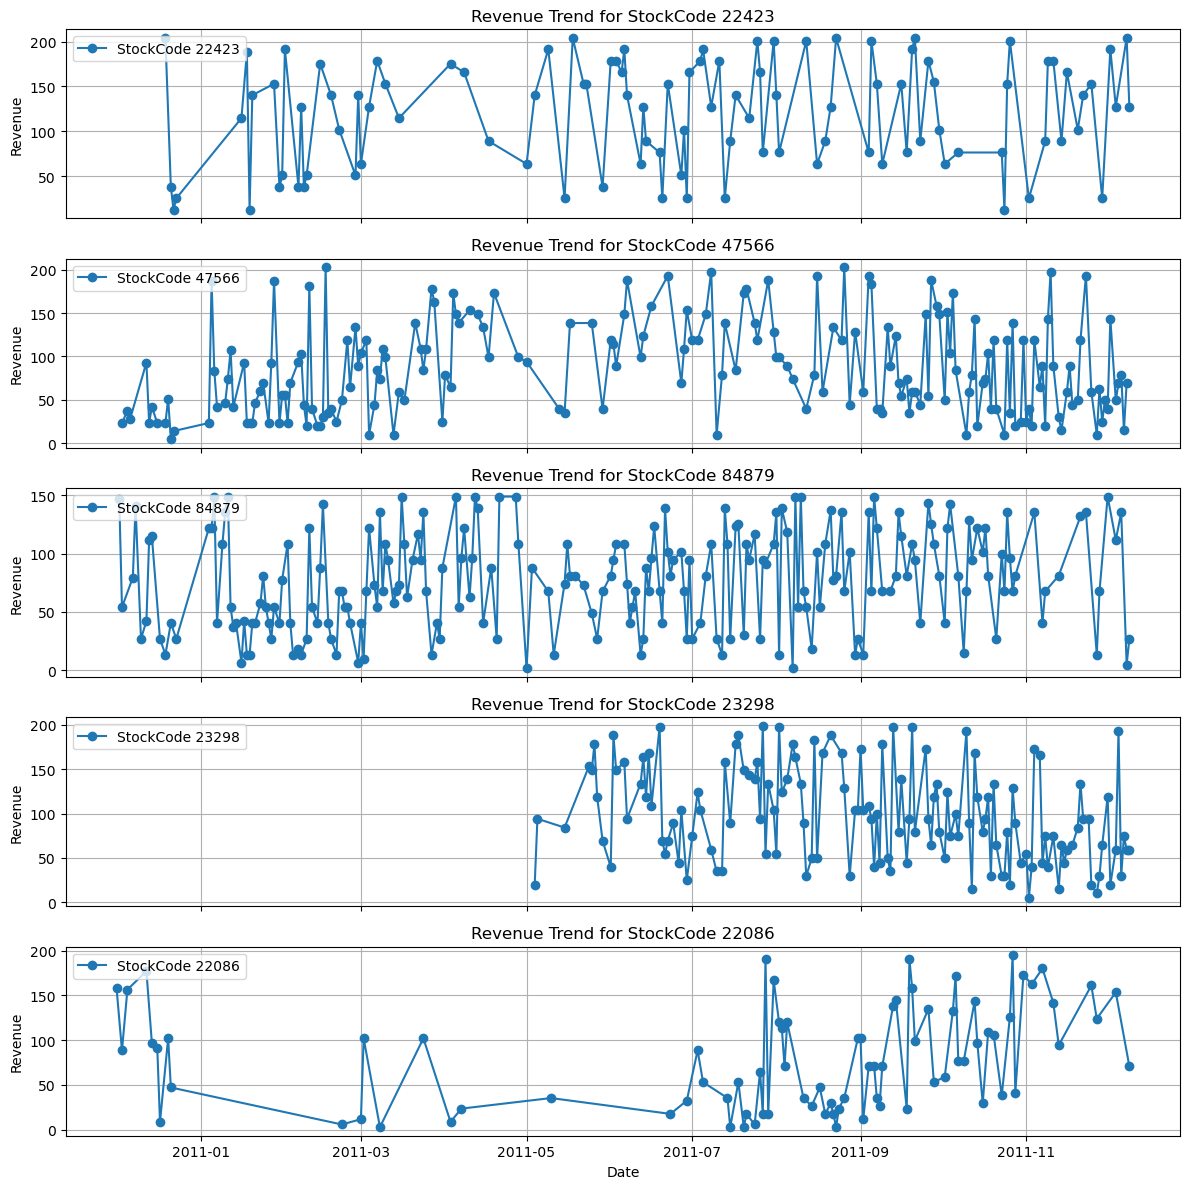

In [132]:
# Calculate the top 5 categories by total revenue
top_categories = data.groupby('StockCode')['Revenue'].sum().sort_values(ascending=False).head(5)

print("Top 5 Categories by Revenue:")
print(top_categories)

fig, axes = plt.subplots(len(top_categories), 1, figsize=(12, 12), sharex=True)

for i, stock_code in enumerate(top_categories.index):
    category_data = daily_data[daily_data['StockCode'] == stock_code].sort_values(by='Date')
    
    # Plot the revenue trend on the corresponding subplot
    axes[i].plot(category_data['Date'], category_data['Revenue'], marker='o', label=f'StockCode {stock_code}')
    axes[i].set_title(f'Revenue Trend for StockCode {stock_code}')
    axes[i].set_ylabel('Revenue')
    axes[i].grid(True)
    axes[i].legend(loc='upper left')

plt.xlabel('Date')
plt.tight_layout()
plt.show()


2. Explore the seasonal variations in sales for different product categories. Are there any categories sensitive to specific time periods?

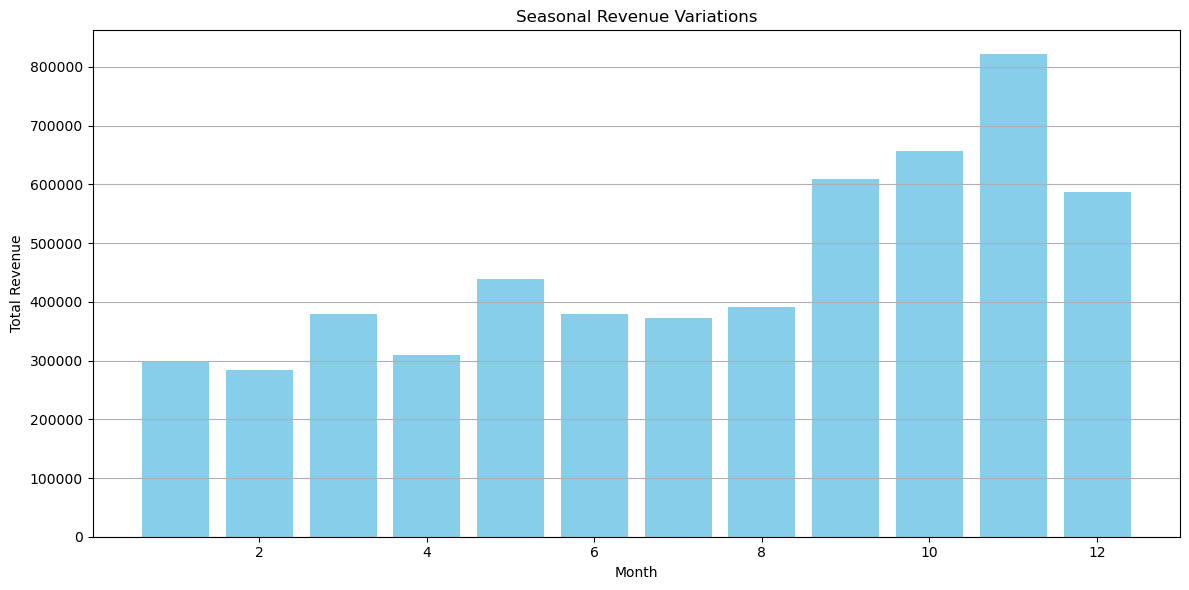

Seasonal sensitivity identified for specific months.


In [112]:
# Analyze sales by season (using month as proxy)
seasonal_sales = data.groupby('Month')['Revenue'].sum()

plt.figure(figsize=(12, 6))
plt.bar(seasonal_sales.index, seasonal_sales.values, color='skyblue')
plt.title('Seasonal Revenue Variations')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print("Seasonal sensitivity identified for specific months.")


3. Analyze shifts in customer purchasing behavior across multiple transactions to identify recurring patterns or significant changes in preferences.

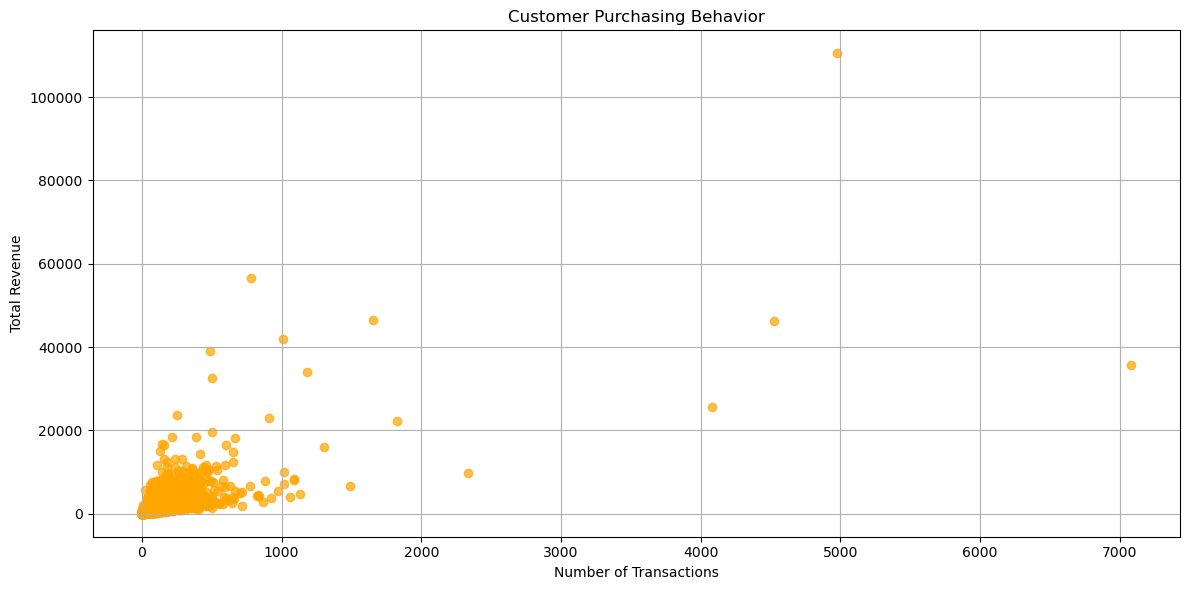

Insights into customer behavior based on transaction frequency and revenue contribution.


In [114]:
# Recurring patterns in customer purchases
customer_patterns = data.groupby('CustomerID').agg({
    'InvoiceNo': 'count',
    'Revenue': 'sum'
}).reset_index()

# Scatter plot of customer patterns
plt.figure(figsize=(12, 6))
plt.scatter(customer_patterns['InvoiceNo'], customer_patterns['Revenue'], alpha=0.7, color='orange')
plt.title('Customer Purchasing Behavior')
plt.xlabel('Number of Transactions')
plt.ylabel('Total Revenue')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Insights into customer behavior based on transaction frequency and revenue contribution.")
